<a href="https://colab.research.google.com/github/heltonmaia/ECT/blob/master/marcosHenrique_Exercicio_classificacao_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conectando ao google drive

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data augmentation

Exemplo com uma imagem

In [0]:
!cd /content
!mkdir preview

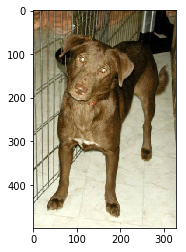

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib import pyplot as plt
import os

datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

img = load_img("/content/gdrive/My Drive/Colab Notebooks/dataset/training_set/dogs/dog.1.jpg") #PIL image
x = img_to_array(img) # Convertendo a imagem para um numpy array
x = x.reshape((1,)+x.shape) # Adicionando mais um campo ao shape do numpy array 

# Mostra a imagem original
plt.imshow(img)


# Limpa o diretorio preview
os.system("rm /content/preview/*")

# O comando .flow abaixo gera batches de imagens transformadas randomicamente
# As imagens resultantes são salvas no diretorio "preview"

i=0
for batch in datagen.flow(x, batch_size=1,save_to_dir='/content/preview', 
                       save_prefix='dog', save_format='jpeg'):
  i+=1
  if i >= 10: # Executa o datagen.flow 10 vezes
    break


plt.show()

    


## Montando os Datasets de treino e teste

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Preparando os dados ( lotes de imagens e seus labels) a partir dos diretórios com as imagens

batch_size = 32

# Augmentation para o treinamento
train_datagen = ImageDataGenerator(
          rescale =1./255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True)


# Augmentation para o teste (apenas rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Leitura das Imagens
train_generator = train_datagen.flow_from_directory(
      '/content/gdrive/My Drive/Colab Notebooks/dataset/training_set',
      target_size=(220,220), # tamanho das imagens
      batch_size = batch_size,
      shuffle = True,
      class_mode='binary') # labels binários


test_generator = test_datagen.flow_from_directory(
      '/content/gdrive/My Drive/Colab Notebooks/dataset/test_set',
      target_size=(220,220), # tamanho das imagens
      batch_size = 1,
      class_mode='binary') # labels binários

Found 8008 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# CONVNET

## Treinameto

Abaixo temos uma rede neural convolucional composta por três camadas de convuluções seguidas por maxpooling, em seguida há o processo de flattening para então termos a rede totalmente conectada composta por duas camadas, a primeira camada possui 64 neurônios, enquanto que a segunda é formada por 1 neurônio, pois trata-se de uma classificação de imagens de forma binária, ou seja, apenas duas classes de classificação.

Por fim, o modelo é salvo na diretório "/content" no formato .json. Os pesos obtidos no treinamento também são salvos nesse diretório.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import model_from_json
from keras import backend as K

K.set_image_dim_ordering('th')

model = Sequential()
# Primeira parte com convoluções e maxpooling
model.add(Conv2D(32,(3,3), input_shape=(3,220,220)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda parte com convoluções e maxpooling
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira parte com convoluções e maxpooling
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten
model.add(Flatten())

# Rede conectada com duas camadas 
model.add(Dense(64)) # 64 neurônios
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1)) # 1 neurônio para clasificação
model.add(Activation('sigmoid')) # Função de ativação sigmoid

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])


model.fit_generator(
    train_generator,
    steps_per_epoch=8000//batch_size,
    epochs=50
)

model_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")
  

Found 8008 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/50
250/250 [==============================] - 4734s 19s/step - loss: 0.6995 - acc: 0.5779
Epoch 2/50
250/250 [==============================] - 107s 427ms/step - loss: 0.5852 - acc: 0.6903
Epoch 3/50
250/250 [==============================] - 100s 401ms/step - loss: 0.5276 - acc: 0.7347
Epoch 4/50
250/250 [==============================] - 103s 412ms/step - loss: 0.4884 - acc: 0.7682
Epoch 5/50
250/250 [==============================] - 101s 403ms/step - loss: 0.4666 - acc: 0.7784
Epoch 6/50
250/250 [==============================] - 102s 408ms/step - loss: 0.4424 - acc: 0.7983
Epoch 7/50
250/250 [==============================] - 102s 407ms/step - loss: 0.4293 - acc: 0.8046
Epoch 8/50
250/250 [==============================] - 100s 401ms/step - loss: 0.4102 - acc: 0.8105
Epoch 9/50
250/250 [==============================] - 100s 401ms/step - loss: 0.4010 - acc: 0.8220
Epoch 10/50
250/250 [=====

# Teste

In [0]:
model.evaluate_generator(test_generator, steps=2000)

[0.6913367200943337, 0.8415]

# Carrega o modelo e os pesos obtidos nas células anteriores e realiza o processo de teste

In [0]:
# Carregando o arquivo .json e criando o modelo
json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#Carregando os pesos para o modelo
loaded_model.load_weights('model.h5')
print('Loaded model from disk')

#Avaliando o modelo carregado no conjunto de teste
loaded_model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

score = loaded_model.evaluate_generator(test_generator,steps=2000)

print("{}: {}".format(loaded_model.metrics_names[1],score[1]*100))
print("{}: {}".format(loaded_model.metrics_names[0],score[0]*100))

Loaded model from disk
acc: 84.15
loss: 69.13367200943335
